# Generating "more" input images by splitting 

In [1]:
#Chose Train or test set
TrainTest = "Train" # "Train" or "Test"

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gudhi as gd
import pickle
import xgboost as xgb
import sklearn.metrics as met

from skimage.measure import label, regionprops
from skimage.morphology import remove_small_objects, erosion

%matplotlib inline

#Paths 
CHALLENGE_PATH = "C:/Chazal/ChallengeIFPEN2018/"

if TrainTest == "Train":
    DATA_PATH = "C:/Chazal/ChallengeIFPEN2018/challenge_fichier_dentrees_dentrainement_prediction_de_la_saturation_dhuile_residuelle/Data/"
else:
    DATA_PATH = "C:/Chazal/ChallengeIFPEN2018/challenge_fichiers_dentrees_de_test_prediction_de_la_saturation_dhuile_residuelle/"

TOOLS_PATH = "C:/Chazal/ChallengeIFPEN2018/challenge_fichier_dentrees_dentrainement_prediction_de_la_saturation_dhuile_residuelle/Tools/"

SUB_IMG_FEAT = "C:/Chazal/ChallengeIFPEN2018/SubImgFeat/"

#Some constants
DEFAULT_SIZE = [175,152,152]

if TrainTest == "Train":
    NB_INPUT_IMG = 400
    StartIdx = 0
else:
    NB_INPUT_IMG = 112
    StartIdx = 400

#Home made tools for persistence features
os.chdir("C:/Seafile/Ma bibliothèque/Chazal2/MyPython36") 
from DTM import *
#from persistent_surface import *
from PdiagFeatures import *

#Classes provided with the data 
os.chdir(TOOLS_PATH)
from Image3D import Image3D
from ImageIO import ImageIO

In [3]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix    
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.externals import joblib
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression

In [4]:
def load_outputs(output_path=CHALLENGE_PATH):
    csv_path = os.path.join(output_path,"challenge_fichier_de_sortie_dentrainement_prediction_de_la_saturation_dhuile_residuelle.csv")
    return pd.read_csv(csv_path,sep=';')

DEFAULT_SIZE = [175,152,152]

def load_data(data_path=DATA_PATH, nb_files=400, size=DEFAULT_SIZE):
    list_img3D = []
    for nb in range(StartIdx,StartIdx+NB_INPUT_IMG):
        file_name = data_path + "input_" + str(nb) + ".raw"
        io = ImageIO(file_name)
        img = io.read(size[0], size[1], size[2])
        list_img3D.append(img)
    return list_img3D

def load_output_data(data_path=DATA_PATH, nb_files=400, size=DEFAULT_SIZE):
    list_out_img3D = []
    for nb in range(StartIdx,StartIdx+NB_INPUT_IMG):
        file_name = data_path + "output_" + str(nb) + ".raw"
        io = ImageIO(file_name)
        img = io.read(size[0], size[1], size[2])
        list_out_img3D.append(img)
    return list_out_img3D


## 1. General functions to extract subimages, compute and save features

In [5]:
#Split a 3D images in several smaller 3D images
def split_img(img,split_size=[2,2,2]): #img is assumed to be an np array
    list_img = []
    #buff = img.get_whole_array()
    sx = np.floor_divide(DEFAULT_SIZE[0],split_size[0])
    sy = np.floor_divide(DEFAULT_SIZE[1],split_size[1])
    sz = np.floor_divide(DEFAULT_SIZE[2],split_size[2])
    for i in range(split_size[0]):
        for j in range(split_size[1]):
            for k in range(split_size[2]):
                list_img.append(img[i*sx:(i+1)*sx,j*sy:(j+1)*sy,k*sz:(k+1)*sz])
    return list_img

#Compute the features for each subimage of an image
def compute_feat_subimg(img,feat_fn,split_size=[2,2,2]):
    list_img = split_img(img,split_size)
    list_feat = []
    for sub_i in list_img:
        list_feat.append(feat_fn(sub_i))
    return list_feat

#Compute and save all features of submimages of all input images
#This one for the case when features are directly computed on the input images
def compute_save_feat_input(input_img_path,img_name,feat_path,feat_name,feat_fn,split_size=[2,2,2]):
    Feat = []
    for idx in range(StartIdx,StartIdx+NB_INPUT_IMG):
        file_name_img = input_img_path + img_name + "_" + str(idx) + ".raw"
        io = ImageIO(file_name_img)
        img0 = io.read(DEFAULT_SIZE[0], DEFAULT_SIZE[1], DEFAULT_SIZE[2])
        img = img0.get_whole_array()
        Feat.append(compute_feat_subimg(img,feat_fn,split_size))
    Feat = np.array(Feat)
    if TrainTest == "Train":
        pickle.dump(Feat,open(feat_path + feat_name + ".dat", "wb"))
    else:
        pickle.dump(Feat,open(feat_path + feat_name + "_test.dat", "wb"))

#For the case when the features are computed from functions on the input images (eg DTM, Density,...)   
#The input image is used as a mask (0 for rock parts, 1 for voids).
def compute_save_feat(input_img_path,img_name,feat_path,feat_name,feat_fn,split_size=[2,2,2],mask_input=False):
    Feat = []
    for idx in range(StartIdx,StartIdx+NB_INPUT_IMG):
        file_name_img1 = input_img_path + img_name + "_" + str(idx) +".dat"
        img1 = pickle.load(open(file_name_img1, "rb"),encoding="latin1")
        if mask_input:
            file_name_img2 = DATA_PATH + "input_" + str(idx) + ".raw"
            io2 = ImageIO(file_name_img2)
            img2 = io2.read(DEFAULT_SIZE[0], DEFAULT_SIZE[1], DEFAULT_SIZE[2]) 
            buff = img2.get_whole_array()
            img = np.multiply(img1.get_whole_array(),buff)
        else:
            img = img1.get_whole_array()
        Feat.append(compute_feat_subimg(img,feat_fn,split_size))
    Feat = np.array(Feat)
    if TrainTest == "Train":
        pickle.dump(Feat,open(feat_path + feat_name + ".dat", "wb"))
    else:
        pickle.dump(Feat,open(feat_path + feat_name + "_test.dat", "wb"))


## 2. Computation of non persistent features

In [6]:
SPLIT_SIZE = [2,2,2]

### 2.1. Volume of voids

In [21]:
#Compute the normalized sum of values in img (voids voxels are assumed to be set to 1 and non-void voxels to 0) 
def void_vol(img):
    tot_vol = np.shape(img)[0]*np.shape(img)[1]*np.shape(img)[2]
    return np.sum(img)/tot_vol

compute_save_feat_input(DATA_PATH,"input",SUB_IMG_FEAT,"Feat_vol_voids",void_vol,SPLIT_SIZE)

### 2.2 Sum of DTM1 values on the void part of images

In [22]:
def void_DTM_vol(img):
    tot_vol = np.shape(img)[0]*np.shape(img)[1]*np.shape(img)[2]
    return np.sum(img)/tot_vol
    
input_img_path = CHALLENGE_PATH + "DTM/" 
img_name = "img_DTM1"
compute_save_feat(input_img_path,img_name,SUB_IMG_FEAT,"Feat_volDTM",void_DTM_vol,SPLIT_SIZE,mask_input=True)

### 2.3 Computation of the area (normalized) of the boundary of the voids

In [23]:
def area_bd(img):
    normalize_factor = np.shape(img)[0]*np.shape(img)[1]
    img1 = erosion(img)
    return (np.sum(img - img1))/normalize_factor
    
input_img_path = CHALLENGE_PATH + "ImgBD/" 
img_name = "ImgBD"
compute_save_feat(input_img_path,img_name,SUB_IMG_FEAT,"Feat_area_bd",area_bd,SPLIT_SIZE,mask_input=False)

### 2.4 Morpho math features (Ivaylo)

In [24]:
def features_extraction(image, min_size_objects=5, DEF_SIZE=[172, 152, 152]):
    '''
    Extract features for a given image.
    '''    
    loc_feats = []
    for u in range(3):
        bin_image_4 = 1. * (image == 1)
        bin_image_4 = erosion(bin_image_4)
        if u >= 1:
            bin_image_4 = erosion(bin_image_4)
        if u >= 2:
            bin_image_4 = erosion(bin_image_4)
        bin_image_4 = remove_small_objects(bin_image_4.astype(bool), min_size=min_size_objects)
        lab_bin_image_4 = label(bin_image_4, background=0)
        regs_4 = regionprops(lab_bin_image_4)
        #  Features: 11 feats
        avg_x = np.mean([re.bbox[3] - re.bbox[0] for re in regs_4[1:]])
        avg_y = np.mean([re.bbox[4] - re.bbox[1] for re in regs_4[1:]])
        avg_z = np.mean([re.bbox[5] - re.bbox[2] for re in regs_4[1:]])
        avg_vol = np.mean([np.prod([re.bbox[i+3] - re.bbox[i] for i in range(3)]) for re in regs_4[1:]])
        avg_val = np.mean([np.prod([re.bbox[i+3] - re.bbox[i] for i in range(3)]) - re.coords.shape[0] for re in regs_4[1:]])
        var_x = np.var([re.bbox[3] - re.bbox[0] for re in regs_4[1:]])
        var_y = np.var([re.bbox[4] - re.bbox[1] for re in regs_4[1:]])
        var_z = np.var([re.bbox[5] - re.bbox[2] for re in regs_4[1:]])
        var_vol = np.var([np.prod([re.bbox[i+3] - re.bbox[i] for i in range(3)]) for re in regs_4[1:]])
        var_val = np.var([np.prod([re.bbox[i+3] - re.bbox[i] for i in range(3)]) - re.coords.shape[0] for re in regs_4[1:]])
        loc_feats += [len(regs_4), avg_x, avg_y, avg_z, avg_vol, avg_val, var_x, var_y, var_z, var_vol, var_val]
    return loc_feats



def morpho_feat(img):
    return features_extraction(img,min_size_objects=5,DEF_SIZE = [np.shape(img)[0],np.shape(img)[1],np.shape(img)[2]])

compute_save_feat_input(DATA_PATH,"input",SUB_IMG_FEAT,"Feat_morpho",morpho_feat,SPLIT_SIZE)

## Load non persistent features

In [7]:
if TrainTest == "Train":
    Feat_vol_voids = pickle.load(open(SUB_IMG_FEAT + "Feat_vol_voids.dat", "rb"),encoding="latin1")
    Feat_volDTM_voids = pickle.load(open(SUB_IMG_FEAT + "Feat_volDTM.dat", "rb"), encoding="latin1")
    Feat_area_bd = pickle.load(open(SUB_IMG_FEAT + "Feat_area_bd.dat", "rb"), encoding="latin1")
    Feat_morpho = pickle.load(open(SUB_IMG_FEAT + "Feat_morpho.dat", "rb"), encoding="latin1")
else:
    Feat_vol_voids = pickle.load(open(SUB_IMG_FEAT + "Feat_vol_voids_test.dat", "rb"),encoding="latin1")
    Feat_volDTM_voids = pickle.load(open(SUB_IMG_FEAT + "Feat_volDTM_test.dat", "rb"), encoding="latin1")
    Feat_area_bd = pickle.load(open(SUB_IMG_FEAT + "Feat_area_bd_test.dat", "rb"), encoding="latin1")
    Feat_morpho = pickle.load(open(SUB_IMG_FEAT + "Feat_morpho_test.dat", "rb"), encoding="latin1")

## 3. Computation of persistence diagrams

### 3.1 General functions to compute persistence diagrams

In [6]:
#Function to compute persistence on cubical complexes - the function is given by the value of the image at each voxel
def persist_img(img):
    lval = []
    img_size = np.shape(img)
    #print("Image size: ", img_size)
    for k in range(img_size[2]):
        for j in range(img_size[1]):
            for i in range(img_size[0]):
                lval.append(img[i,j,k]) 
    cub_cpx = gd.CubicalComplex(img_size,lval)
    #print("cubical cpx built with size: ", cub_cpx.num_simplices(), " - ", len(lval))
    return cub_cpx.persistence(homology_coeff_field=2, min_persistence=0)

#Function to compute persistence of a function on defined on the voxels of a binary image
def persist_img_fn(img, fn, void_id=1, void_val=1000): #void_id has to be the value taken by img at the "void" points 
    lval = []
    img_size = np.shape(img)
    for k in range(img_size[2]):
        for j in range(img_size[1]):
            for i in range(img_size[0]):
                if img[i,j,k]==void_id :
                    lval.append(void_val)
                else:
                    lval.append(fn(i,j,k)) 
    cub_cpx = gd.CubicalComplex(img_size,lval)
    return cub_cpx.persistence(homology_coeff_field=2, min_persistence=0)

#Coordinate functions
def fn_z(i,j,k):
    return k

def fn_x(i,j,k):
    return i

def fn_y(i,j,k):
    return j


#Compute the persistence diagrams of each subimage of an image
def compute_persistence_subimg(img,split_size=[2,2,2]):
    list_img = split_img(img,split_size)
    list_dgms = []
    for sub_i in list_img:
        list_dgms.append(persist_img(sub_i))
    return list_dgms

### 3.2 Functions to process persistence diagrams

In [7]:
def get_dgm_dim012(dgm,details=False):
    dgm0 = []
    dgm1 = []
    dgm2 = []
    for p in dgm:
        if (p[0]==0):
            dgm0.append(p)
        elif (p[0]==1):
            dgm1.append(p)
        elif (p[0]==2):
            dgm2.append(p)
    if details == True:
        print("number of pairs in dim 0: ", len(dgm0))
        print("number of pairs in dim 1: ", len(dgm1))
        print("number of pairs in dim 2: ", len(dgm2))
        print("number of pairs in dim 3: ", len(dgm3))
        print("total number of pairs (for check): ", len(dgm0)+len(dgm1)+len(dgm2)+len(dgm3))
    return dgm0, dgm1, dgm2

def get_list_dgm_per_dim(list_dgm):
    list_dgm0 =[]
    list_dgm1 =[]
    list_dgm2 =[]
    for dgm in list_dgm:
        dgm0, dgm1, dgm2 = get_dgm_dim012(dgm)
        list_dgm0.append(dgm0)
        list_dgm1.append(dgm1)
        list_dgm2.append(dgm2)
    return list_dgm0, list_dgm1, list_dgm2

def remove_essential(dgm,max_death=np.inf):
    dgm_ne =[]
    for p in dgm:
        if (p[1][1] < max_death):
                dgm_ne.append(p)
    return dgm_ne

def remove_dim_and_essential(list_dgm, max_death=np.inf):
    list_dgm_nd = []   #for dim 0, also remove the point with infinite persistence
    for dgm in list_dgm:
        dgm_nd = []
        for p in dgm:
            if (p[1][1] < max_death):
                dgm_nd.append(p[1])
        list_dgm_nd.append(dgm_nd)
    return list_dgm_nd

### 3.3 Functions to compute persistence images

In [8]:
def weight_fn(x,y):
    return np.abs(y)   #y*y for DTM (DTM30)

def get_persistence_images(list_dgm_nd,x_min,x_max,nb_x_step,y_min,y_max,nb_y_step,sigma2, weight=weight_fn):
    Feat_pers = []
    Pers_img = []
    for dgm in list_dgm_nd:
        X,Y,IPers = persistence_surf(dgm,x_min,x_max,nb_x_step,y_min,y_max,nb_y_step,sigma2,\
                          weight=weight_fn)
        Pers_img.append(IPers)
        Feat_pers.append(np.ravel(IPers))
    Feat_pers = np.array(Feat_pers)
    return Feat_pers, Pers_img

### Computation of persistence diagrams for DTM1

In [30]:
kNN = 1
MAX_INV = 30

for nb in range(StartIdx,StartIdx+NB_INPUT_IMG):
    file_name = "img_DTM" + str(kNN) + "_" + str(nb) + ".dat"
    DTM_img = pickle.load(open(CHALLENGE_PATH + "DTM/"+ file_name, "rb"),encoding="latin1")
    DTM_img_inv = MAX_INV - DTM_img.get_whole_array()
    print(np.shape(DTM_img_inv))
    list_dgms = compute_persistence_subimg(DTM_img_inv,split_size=SPLIT_SIZE)
    dgm_id=0
    for dgm in list_dgms:
        file_name_dgm = "dgm_DTM" + str(kNN) + "_" + str(nb) + "_" + str(dgm_id) + ".dat"
        pickle.dump(dgm,open(SUB_IMG_FEAT + "DTM/"+ file_name_dgm, "wb"))
        dgm_id +=1
    print("DTM dgm computed: ", nb)

(175, 152, 152)
DTM dgm computed:  0
(175, 152, 152)
DTM dgm computed:  1
(175, 152, 152)
DTM dgm computed:  2
(175, 152, 152)
DTM dgm computed:  3
(175, 152, 152)
DTM dgm computed:  4
(175, 152, 152)
DTM dgm computed:  5
(175, 152, 152)
DTM dgm computed:  6
(175, 152, 152)
DTM dgm computed:  7
(175, 152, 152)
DTM dgm computed:  8
(175, 152, 152)
DTM dgm computed:  9
(175, 152, 152)
DTM dgm computed:  10
(175, 152, 152)
DTM dgm computed:  11
(175, 152, 152)
DTM dgm computed:  12
(175, 152, 152)
DTM dgm computed:  13
(175, 152, 152)
DTM dgm computed:  14
(175, 152, 152)
DTM dgm computed:  15
(175, 152, 152)
DTM dgm computed:  16
(175, 152, 152)
DTM dgm computed:  17
(175, 152, 152)
DTM dgm computed:  18
(175, 152, 152)
DTM dgm computed:  19
(175, 152, 152)
DTM dgm computed:  20
(175, 152, 152)
DTM dgm computed:  21
(175, 152, 152)
DTM dgm computed:  22
(175, 152, 152)
DTM dgm computed:  23
(175, 152, 152)
DTM dgm computed:  24
(175, 152, 152)
DTM dgm computed:  25
(175, 152, 152)
DTM dg

DTM dgm computed:  213
(175, 152, 152)
DTM dgm computed:  214
(175, 152, 152)
DTM dgm computed:  215
(175, 152, 152)
DTM dgm computed:  216
(175, 152, 152)
DTM dgm computed:  217
(175, 152, 152)
DTM dgm computed:  218
(175, 152, 152)
DTM dgm computed:  219
(175, 152, 152)
DTM dgm computed:  220
(175, 152, 152)
DTM dgm computed:  221
(175, 152, 152)
DTM dgm computed:  222
(175, 152, 152)
DTM dgm computed:  223
(175, 152, 152)
DTM dgm computed:  224
(175, 152, 152)
DTM dgm computed:  225
(175, 152, 152)
DTM dgm computed:  226
(175, 152, 152)
DTM dgm computed:  227
(175, 152, 152)
DTM dgm computed:  228
(175, 152, 152)
DTM dgm computed:  229
(175, 152, 152)
DTM dgm computed:  230
(175, 152, 152)
DTM dgm computed:  231
(175, 152, 152)
DTM dgm computed:  232
(175, 152, 152)
DTM dgm computed:  233
(175, 152, 152)
DTM dgm computed:  234
(175, 152, 152)
DTM dgm computed:  235
(175, 152, 152)
DTM dgm computed:  236
(175, 152, 152)
DTM dgm computed:  237
(175, 152, 152)
DTM dgm computed:  238
(1

### Computation of persistence diagrams for density function

In [37]:
for idx in range(StartIdx,StartIdx+NB_INPUT_IMG):
    filename = "SetDensity2_" + str(idx) + ".dat"
    img0 = pickle.load(open(CHALLENGE_PATH + "SetDensity2/" + filename,"rb"),encoding="latin1")
    img = img0.get_whole_array()
    list_dgms = compute_persistence_subimg(img,split_size=SPLIT_SIZE)
    dgm_id = 0
    for dgm in list_dgms:
        file_dgm=  "dgm_SetDensity2_" + str(idx) + "_" + str(dgm_id) + ".dat"
        pickle.dump(dgm,open(SUB_IMG_FEAT + "SetDensity2/" + file_dgm,"wb"))
        dgm_id +=1
    print("Dgm computed:", idx)

Dgm computed: 0
Dgm computed: 1
Dgm computed: 2
Dgm computed: 3
Dgm computed: 4
Dgm computed: 5
Dgm computed: 6
Dgm computed: 7
Dgm computed: 8
Dgm computed: 9
Dgm computed: 10
Dgm computed: 11
Dgm computed: 12
Dgm computed: 13
Dgm computed: 14
Dgm computed: 15
Dgm computed: 16
Dgm computed: 17
Dgm computed: 18
Dgm computed: 19
Dgm computed: 20
Dgm computed: 21
Dgm computed: 22
Dgm computed: 23
Dgm computed: 24
Dgm computed: 25
Dgm computed: 26
Dgm computed: 27
Dgm computed: 28
Dgm computed: 29
Dgm computed: 30
Dgm computed: 31
Dgm computed: 32
Dgm computed: 33
Dgm computed: 34
Dgm computed: 35
Dgm computed: 36
Dgm computed: 37
Dgm computed: 38
Dgm computed: 39
Dgm computed: 40
Dgm computed: 41
Dgm computed: 42
Dgm computed: 43
Dgm computed: 44
Dgm computed: 45
Dgm computed: 46
Dgm computed: 47
Dgm computed: 48
Dgm computed: 49
Dgm computed: 50
Dgm computed: 51
Dgm computed: 52
Dgm computed: 53
Dgm computed: 54
Dgm computed: 55
Dgm computed: 56
Dgm computed: 57
Dgm computed: 58
Dgm com

## Computation of persistence images on normalized diagrams

### Functions to load already computed diagrams

In [8]:
#To load persistence diagrams of DTM function
def load_DTM_dgm(idx,sub_idx, kNN=1):
    file_name_dgm = SUB_IMG_FEAT + "DTM/dgm_DTM" + str(kNN) + "_" + str(idx) + "_" + str(sub_idx) + ".dat"
    return pickle.load(open(file_name_dgm, "rb"), encoding="latin1")

#To get all DTM diagrams
def load_all_DTM_dgm(kNN=1,split_size=[2,2,2]):
    list_dgm_DTM = []
    for idx in range(StartIdx,StartIdx+NB_INPUT_IMG):
        for sub_idx in range(split_size[0]*split_size[1]*split_size[2]):
            list_dgm_DTM.append(load_DTM_dgm(idx, sub_idx, kNN))
    return list_dgm_DTM

#To load persistence diagrams of the SetIntensity function
def load_all_dgm_SetIntensity2(split_size=[2,2,2]):
    list_intensity2_dgm = []
    for idx in range(StartIdx,StartIdx+NB_INPUT_IMG):
        for sub_idx in range(split_size[0]*split_size[1]*split_size[2]):
            file_dgm=  "dgm_SetDensity2_" + str(idx) + "_" + str(sub_idx) + ".dat"
            dgm = pickle.load(open(SUB_IMG_FEAT + "SetDensity2/" + file_dgm,"rb"),encoding="latin1")
            list_intensity2_dgm.append(dgm)
    return list_intensity2_dgm

### Min-max normalization of diagrams (for persistence images computations) 

In [9]:
#def birth_lifespan_min_max(diag_list,max_death=np.inf):
#    bd_min_max = []
#    for dgm in diag_list:
#        if len(dgm) == 0:
#            bd_min_max.append([0,1,0,1])
#        else:
#            birth = []
#            lifespan = []
#            for pt in dgm:
#                birth.append(pt[0])
#                if  pt[1] < max_death:
#                    lifespan.append(pt[1]-pt[0])
#            bd_min_max.append([np.min(birth),np.max(birth),np.min(lifespan),np.max(lifespan)])
#    return bd_min_max

def birth_lifespan_min_max(diag_list,max_death=np.inf): #Warning!!!!!!  this one is not about lifespan
    bd_min_max = []
    for dgm in diag_list:
        if len(dgm) == 0:
            bd_min_max.append([0,1,0,1])
        else:
            birth = []
            lifespan = []
            for pt in dgm:
                birth.append(pt[0])
                if  pt[1] < max_death:
                    lifespan.append(pt[1])
            bd_min_max.append([np.min(birth),np.max(birth),np.min(lifespan),np.max(lifespan)])
    return bd_min_max

def fn_scale(x,a,b):
    if a == b:
        sx = 1.0
    else:
        sx = (x-a)/(b-a)
    return sx

def min_max_dgm_normalize(diag_list,max_death=np.inf):
    bd_min_max = birth_lifespan_min_max(diag_list,max_death)
    diag_norm_list = []
    for idx in range(len(diag_list)):
        dgm = diag_list[idx]
        dgm_n = []
        for pt in dgm:
            b = fn_scale(pt[0],bd_min_max[idx][0],bd_min_max[idx][1])
            #d = b + fn_scale(pt[1]-pt[0],bd_min_max[idx][2],0)
            #d = fn_scale(pt[1],bd_min_max[idx][2],bd_min_max[idx][3])
            d = fn_scale(pt[1],0.0,bd_min_max[idx][3])
            dgm_n.append((b,d))
        diag_norm_list.append(dgm_n)
    return diag_norm_list

def weight_fn(x,y):
    return np.abs(y)   #y*y for DTM (DTM30)

### Function to compute and save persistence images 

In [10]:
def pers_img_Feat(list_dgm, save_filename, nb_x_step, nb_y_step, sigma_2=0.0025, max_death=np.inf,w_fn=weight_fn):
    list_dgm0, list_dgm1, list_dgm2 = get_list_dgm_per_dim(list_dgm)
    list_dgm0_nd = min_max_dgm_normalize(remove_dim_and_essential(list_dgm0, max_death),max_death)
    list_dgm1_nd = min_max_dgm_normalize(remove_dim_and_essential(list_dgm1, max_death),max_death)

    list_dgm2_nd = min_max_dgm_normalize(remove_dim_and_essential(list_dgm2, max_death),max_death)
    
    Feat_pers0, Pers_img_0 = get_persistence_images(list_dgm0_nd,0.0,1.0,nb_x_step,0.0,1.0,nb_y_step,sigma_2,\
                                                          weight=w_fn)
    if TrainTest == "Train":
        file_name_dgm = save_filename + "_pers0.dat"
    else:
        file_name_dgm = save_filename + "_pers0_test.dat"
    pickle.dump(Feat_pers0,open(SUB_IMG_FEAT + file_name_dgm, "wb"))
    print(file_name_dgm, "has been computed and saved")
    
    Feat_pers1, Pers_img_1 = get_persistence_images(list_dgm1_nd,0.0,1.0,nb_x_step,0.0,1.0,nb_y_step,sigma_2,\
                                                          weight=w_fn)
    if TrainTest == "Train":
        file_name_dgm = save_filename + "_pers1.dat"
    else:
        file_name_dgm = save_filename + "_pers1_test.dat"
    pickle.dump(Feat_pers1,open(SUB_IMG_FEAT + file_name_dgm, "wb"))
    print(file_name_dgm, "has been computed and saved")
    
    Feat_pers2, Pers_img_2 = get_persistence_images(list_dgm2_nd,0.0,1.0,nb_x_step,0.0,1.0,nb_y_step,sigma_2,\
                                                          weight=w_fn)
    if TrainTest == "Train":
        file_name_dgm = save_filename + "_pers2.dat"
    else:
        file_name_dgm = save_filename + "_pers2_test.dat"
    pickle.dump(Feat_pers2,open(SUB_IMG_FEAT + file_name_dgm, "wb"))
    print(file_name_dgm, "has been computed and saved")

### Compute and save all persistence images

In [42]:
nb_x_step = 5 #8
nb_y_step = 6 #5
sigma_2 = 0.025 #0.025

list_dgm_DTM1 = load_all_DTM_dgm(kNN=1)
list_intensity2_dgm = load_all_dgm_SetIntensity2()


dgm_names = [list_dgm_DTM1,list_intensity2_dgm]
file_names = ["Feat_DTM1_scaled","Feat_SetIntensity2_scaled"]


for idx in range(len(dgm_names)):
    list_dgm = dgm_names[idx]
    file_name_dgm = file_names[idx]
    pers_img_Feat(list_dgm,file_name_dgm,nb_x_step,nb_y_step,sigma_2,199.9,weight_fn)

Feat_DTM1_scaled_pers0.dat has been computed and saved
Feat_DTM1_scaled_pers1.dat has been computed and saved
Feat_DTM1_scaled_pers2.dat has been computed and saved
Feat_SetIntensity2_scaled_pers0.dat has been computed and saved
Feat_SetIntensity2_scaled_pers1.dat has been computed and saved
Feat_SetIntensity2_scaled_pers2.dat has been computed and saved


## Load persistence features

In [12]:
file_names = ["Feat_DTM1_scaled_","Feat_SetIntensity2_scaled_"]

pers_test = ["pers0_test.dat","pers1_test.dat","pers2_test.dat"]
pers_train = ["pers0.dat","pers1.dat","pers2.dat"]

if TrainTest == "Train":
    pers = pers_train
else:
    pers = pers_test

Feat_names = ["Feat_DTM1_","Feat_SetIntensity2_"]
Feat_names_pers = ["pers0","pers1","pers2"]

variable_file_names=[]
for idx in range(len(file_names)):
    for jdx in range(len(pers_test)):
        vn = Feat_names[idx] + Feat_names_pers[jdx]
        fn = file_names[idx] + pers[jdx]
        variable_file_names.append([vn,fn])
            
#Create the variables            
dct = dict()
for vn in variable_file_names:
    dct[vn[0]] = []
for k,v in dct.items():
    exec("%s=%s" % (k,v))

v = locals()
for vn in variable_file_names:
    file_name = vn[1]
    v[vn[0]] = pickle.load(open(SUB_IMG_FEAT+file_name, "rb"), encoding="latin1") 

In [13]:
np.shape(Feat_DTM1_pers1)

(3200, 30)

## Prepare features for training and testing

In [13]:
#Reshape non persistent features
nb_subimg= SPLIT_SIZE[0]*SPLIT_SIZE[1]*SPLIT_SIZE[2]
Feat_vol_voids = np.reshape(Feat_vol_voids,(NB_INPUT_IMG*nb_subimg,1))
Feat_volDTM_voids = np.reshape(Feat_volDTM_voids,(NB_INPUT_IMG*nb_subimg,1))
Feat_area_bd = np.reshape(Feat_area_bd,(NB_INPUT_IMG*nb_subimg,1))
Feat_morpho = np.reshape(Feat_morpho,(NB_INPUT_IMG*nb_subimg,33))

#Persistence features
Feat_DTM1_pers = np.concatenate([Feat_DTM1_pers0,Feat_DTM1_pers1,Feat_DTM1_pers2],axis=1)
Feat_SetIntensity2_pers = np.concatenate([Feat_SetIntensity2_pers0,Feat_SetIntensity2_pers1,Feat_SetIntensity2_pers2],axis=1)


#### Prepare the output variable (y_sor)

In [37]:
#outputs = load_outputs(output_path=CHALLENGE_PATH)
#y_sor0 = outputs['sor'].values.reshape(NB_INPUT_IMG,1)
#y_sor = np.repeat(y_sor0,8,axis=0)


nb_split = SPLIT_SIZE[0]*SPLIT_SIZE[1]*SPLIT_SIZE[2]
size = DEFAULT_SIZE
nb_voxels = DEFAULT_SIZE[0]*DEFAULT_SIZE[1]*DEFAULT_SIZE[2]
y_sor = []

for nb in range(NB_INPUT_IMG):
    file_name = DATA_PATH + "input_" + str(nb) + ".raw"
    io = ImageIO(file_name)
    img0 = io.read(size[0], size[1], size[2])
    img = img0.get_whole_array()
    io =  ImageIO(DATA_PATH + "output_" + str(nb) + ".raw")
    img0_out = io.read(size[0],size[1],size[2])
    img_out = img0_out.get_whole_array()
    list_sub_img = split_img(img)
    list_sub_img_out = split_img(img_out)
    for idx in range (nb_split):
        oil = (list_sub_img_out[idx] >= 3)
        y_sor.append(np.sum(oil)/np.sum(img))



#To encode the material labels
encoder = LabelEncoder()
material_cat_encoded = encoder.fit_transform(outputs["material"])
material_cat_encoded = material_cat_encoded.reshape(NB_INPUT_IMG,1)
Feat_mat = np.repeat(material_cat_encoded,8,axis=0)

In [38]:
Feat = np.concatenate([Feat_mat,Feat_vol_voids,Feat_volDTM_voids,Feat_area_bd,Feat_morpho,\
                       Feat_DTM1_pers,Feat_SetIntensity2_pers],axis=1)

print(np.shape(Feat))

(3200, 217)


### To split the data consistently 

In [51]:
Feat = np.concatenate([Feat_mat,Feat_vol_voids,Feat_volDTM_voids,Feat_area_bd,Feat_morpho,\
                       Feat_DTM1_pers,Feat_SetIntensity2_pers],axis=1)

Feat_rs = np.reshape(Feat,(NB_INPUT_IMG,8,np.shape(Feat)[1]))
y_sor_rs = np.reshape(y_sor,(NB_INPUT_IMG,8))
Feat_mat_rs = np.reshape(Feat_mat,(NB_INPUT_IMG,8))

Feature_rs_train, Feature_rs_test, y_rs_train, y_rs_test, mat_rs_train, mat_rs_test =\
train_test_split(Feat_rs, y_sor_rs, Feat_mat_rs, test_size = 0.2)

In [52]:
nb_train = np.shape(Feature_rs_train)[0]
nb_test = np.shape(Feature_rs_test)[0]
nb_feat = np.shape(Feat)[1]

Feature_train = np.reshape(Feature_rs_train,(nb_train*8,nb_feat))
Feature_test = np.reshape(Feature_rs_test,(nb_test*8,nb_feat))
y_train = np.reshape(y_rs_train,(nb_train*8,1))
y_test = np.reshape(y_rs_test,(nb_test*8,1))
mat_train = np.reshape(mat_rs_train,(nb_train*8,1)) 
mat_test = np.reshape(mat_rs_test,(nb_test*8,1))

## Regression on sor 

In [45]:
#Feature_train, Feature_test, y_train, y_test, mat_train, mat_test = train_test_split(Feat, y_sor, Feat_mat, test_size = 0.2)

In [53]:
#scaler = StandardScale#r()
scaler = MinMaxScaler()
scaler.fit(Feature_train)
X = scaler.transform(Feature_train)


#param_grid = [{'n_estimators': [30, 40, 50, 70, 100, 200, 250], 'learning_rate': [0.05, 0.07, 0.1, 0.12, 0.14] }]
param_grid = [{'n_estimators': [50, 80, 100, 150, 200], 'learning_rate': [0.03, 0.06, 0.1, 0.12] ,\
               'max_depth': [3, 4], 'booster': ["gbtree", "dart"]}]

#RF = GradientBoostingRegressor()
RF = xgb.XGBRegressor()
grid_search = GridSearchCV(RF, param_grid, cv=4,
                           scoring='neg_mean_squared_error', return_train_score=True)

#grid_search = GridSearchCV(RF, param_grid, cv=4,
#                           scoring='neg_mean_absolute_error', return_train_score=True)



grid_search.fit(X, y_train)

print("Best parameters:  ", grid_search.best_params_)

X_train = X
X_test = scaler.transform(Feature_test)

Best parameters:   {'booster': 'gbtree', 'learning_rate': 0.06, 'max_depth': 3, 'n_estimators': 150}


In [56]:
RFbest = grid_search.best_estimator_

#To plot all the scores from grid search
cvres = grid_search.cv_results_
for sc1, sc2, sc3 in zip(cvres["mean_test_score"], cvres["mean_train_score"], cvres["params"]):
    print("Test: ", -sc1, " - Train: ", -sc2, "  ", sc3)

Test:  0.010706668084908683  - Train:  0.010709726415188808    {'booster': 'gbtree', 'learning_rate': 0.03, 'max_depth': 3, 'n_estimators': 50}
Test:  0.001810013726054193  - Train:  0.0018017347574337428    {'booster': 'gbtree', 'learning_rate': 0.03, 'max_depth': 3, 'n_estimators': 80}
Test:  0.000603453272806765  - Train:  0.0005896429605971811    {'booster': 'gbtree', 'learning_rate': 0.03, 'max_depth': 3, 'n_estimators': 100}
Test:  0.0001163141197355908  - Train:  9.415382691753841e-05    {'booster': 'gbtree', 'learning_rate': 0.03, 'max_depth': 3, 'n_estimators': 150}
Test:  9.202164163003332e-05  - Train:  6.449656632733354e-05    {'booster': 'gbtree', 'learning_rate': 0.03, 'max_depth': 3, 'n_estimators': 200}
Test:  0.010706668084908683  - Train:  0.010709726415188808    {'booster': 'gbtree', 'learning_rate': 0.03, 'max_depth': 4, 'n_estimators': 50}
Test:  0.0018114665893805895  - Train:  0.0018008616802904667    {'booster': 'gbtree', 'learning_rate': 0.03, 'max_depth': 4, '

Train:
0.7612259057893817
0.0076659616290542
Test:
0.7299282476608226
0.008294151649748538


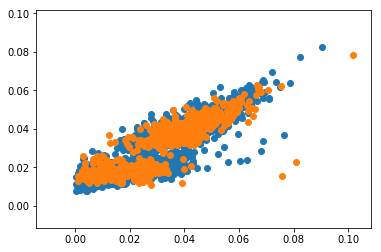

In [58]:
other_option = True

if other_option:
    scaler = MinMaxScaler()
    scaler.fit(Feature_train)
    X_train = scaler.transform(Feature_train)
    X_test = scaler.transform(Feature_test)
    RFbest = xgb.XGBRegressor(n_estimators=150, learning_rate=0.06)
    RFbest.fit(X_train,y_train)

y_pred = RFbest.predict(X_test)




print('Train:')
print(met.r2_score(y_train, RFbest.predict(X_train)))
print(np.sqrt(met.mean_squared_error(y_train, RFbest.predict(X_train))))
print('Test:')
print(met.r2_score(y_test, y_pred))
print(np.sqrt(met.mean_squared_error(y_test, y_pred)))

#RFbest = grid_search.best_estimator_
plt.scatter(y_train,RFbest.predict(X_train))
plt.scatter(y_test,RFbest.predict(X_test))

(2560, 1)
2560
(2560,)


ValueError: x and y must be the same size

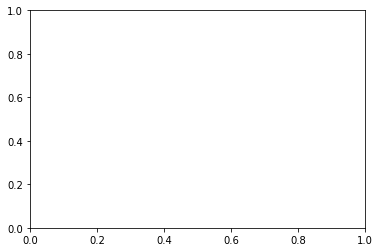

In [60]:
print(np.shape(y_train))
print(len(y_train))
print(np.shape(RFbest.predict(X_train)))

plt.scatter(y_train,RFbest.predict(X_train)-y_train)
plt.scatter(y_test,RFbest.predict(X_test)-y_test)

### Linear regression

In [53]:
#Feat = np.concatenate([Feat_mat,Feat_vol_voids,Feat_volDTM_voids,Feat_area_bd,Feat_morpho],axis=1)
Feat = np.concatenate([Feat_mat,Feat_DTM1_pers,Feat_SetIntensity2_pers],axis=1)
#Feat_DTM1_pers,Feat_SetIntensity2_pers

print(np.shape(Feat))

Feature_train, Feature_test, y_train, y_test, mat_train, mat_test = train_test_split(Feat, y_sor, Feat_mat, test_size = 0.2)

(3200, 181)


In [50]:
scaler = MinMaxScaler()
scaler.fit(Feature_train)
X_train = scaler.transform(Feature_train)
X_test = scaler.transform(Feature_test)

clf = LinearRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print('Train:')
print(met.r2_score(y_train, clf.predict(X_train)))
print(np.sqrt(met.mean_squared_error(y_train, clf.predict(X_train))))
print('Test:')
print(met.r2_score(y_test, y_pred))
print(np.sqrt(met.mean_squared_error(y_test, y_pred)))

Train:
0.7170519294818085
0.00836511707039146
Test:
0.607773800135327
0.010006650930397223


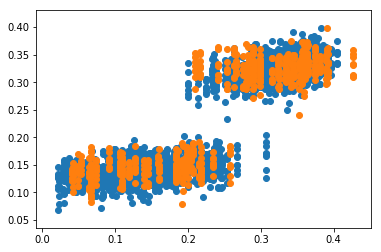

In [91]:
plt.scatter(y_train,clf.predict(X_train))
plt.scatter(y_test,clf.predict(X_test))

## Draft experiments 

In [36]:
list_diff= []
size = DEFAULT_SIZE
nb_voxels = DEFAULT_SIZE[0]*DEFAULT_SIZE[1]*DEFAULT_SIZE[2]

for nb in range(NB_INPUT_IMG):
    Y = outputs['sor']
    file_name = DATA_PATH + "input_" + str(nb) + ".raw"
    io = ImageIO(file_name)
    img0 = io.read(size[0], size[1], size[2])
    img = img0.get_whole_array()
    io =  ImageIO(DATA_PATH + "output_" + str(nb) + ".raw")
    img0_out = io.read(size[0],size[1],size[2])
    img_out = img0_out.get_whole_array()
    oil = (img_out >= 3)
    list_diff.append(Y[nb] - np.sum(oil)/np.sum(img))

print(np.min(np.abs(list_diff)))
print(np.max(np.abs(list_diff)))
print(np.histogram(list_diff))    
    
#print("sor value: ", Y[nb])
#print("Vol void (nb of voxels): ", np.sum(img))
#print("Vol residual oil: ", np.sum(oil))
#print("ratio: ", np.sum(oil)/np.sum(img))

3.203307824783952e-05
0.05368783889070344
(array([  3,   7,  49, 111, 131,  65,  21,   9,   3,   1], dtype=int64), array([-0.0403217 , -0.03092075, -0.02151979, -0.01211884, -0.00271788,
        0.00668307,  0.01608402,  0.02548498,  0.03488593,  0.04428688,
        0.05368784]))


In [ ]:
nb_split = SPLIT_SIZE[0]*SPLIT_SIZE[1]*SPLIT_SIZE[2]
size = DEFAULT_SIZE
nb_voxels = DEFAULT_SIZE[0]*DEFAULT_SIZE[1]*DEFAULT_SIZE[2]
y_sor = []

for nb in range(NB_INPUT_IMG):
    file_name = DATA_PATH + "input_" + str(nb) + ".raw"
    io = ImageIO(file_name)
    img0 = io.read(size[0], size[1], size[2])
    img = img0.get_whole_array()
    io =  ImageIO(DATA_PATH + "output_" + str(nb) + ".raw")
    img0_out = io.read(size[0],size[1],size[2])
    img_out = img0_out.get_whole_array()
    list_sub_img = split_img(img)
    list_sub_img_out = split_img(img_out)
    for idx in range (nb_split):
        oil = (list_sub_img_out[idx] >= 3)
        y_sor.append(np.sum(oil)/np.sum(img))


[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 2 2 1 1 2 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 2 2 2
 1 1 1 1 1 1 1 2 2 2 2 2 2 2 1 1 1 1 1 2 1 1 1 1 2 2 2 2 2 2 2 2 2 1 1 1 1
 1 1 1 1]
209151


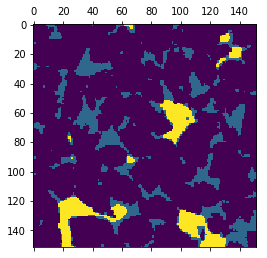

In [26]:
slice_idx = 80
plt.matshow(img0_out.get_plane(slice_idx))
print(img_out[slice_idx,60,:])

ct = 0
for p in np.ravel(img_out):
    if p >= 3:
        ct+=1
print(ct)